# Obtaining Daily Volatility 
Get hourly candlestick data from Binance Klines

### We calculate Realised Volatility for x days given a trading pair on Binance

In [13]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import concurrent.futures
import numpy as np
import time

def fetch_data(symbol, interval, start_time, end_time):
    url = "https://api.binance.com/api/v3/klines"
    params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': 1000
    }
    data = requests.get(url, params=params).json()
    return data

def threaded_fetching(symbol, interval, start_time, end_time):

    delta = 1000 * 60 * 60 * 24  # 1 day in milliseconds
    all_data = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # distribute requests
        futures = [executor.submit(fetch_data, symbol, interval, t, min(t+delta, end_time)) for t in range(start_time, end_time, delta)]
        for future in concurrent.futures.as_completed(futures):
            all_data.extend(future.result())
    df = pd.DataFrame(all_data, columns=['open_time','open','high','low','close','volume','close_time','quote_asset_volume',
                                         'number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'])
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    return df

def calculate_volatility(df):
    df['close'] = pd.to_numeric(df['close'])
    df.set_index('open_time', inplace=True)
    df = df.resample('1H').last()
    df['log_return'] = np.log(df['close'] / df['close'].shift())
    df = df.resample('1D').std()
    df['log_return'] = df['log_return'] * np.sqrt(24) * 100  # annualize volatility
    return df[['log_return']]

def plot_volatility(df):
    df.plot()
    plt.title("Daily Realised Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility (%)")
    plt.grid(True)
    plt.show()


### TODO: If trading pair not on Binance, write function to find volatility by routing through USDT

# Calculating LVR based on theoretical Formula

$$
\frac{l(\sigma^2,P)}{V(P)} = \frac{\frac{L\sigma^2}{4}\sqrt{P}}{L(2\sqrt{P} \  - \ P/\sqrt{P_b} \ - \ \sqrt{P_a})}
$$

$$
\frac{l(\sigma^2,P)}{V(P)} = \frac{\sigma^2\sqrt{P}}{4(2\sqrt{P} \  - \ P/\sqrt{P_b} \ - \ \sqrt{P_a})}
$$

### We can obtain L, Pb and Pa of a given position ID on Uniswap V3 using Revert Finance

In [10]:
import requests
import pprint

def get_position_data(position_id):
    url = f'https://staging-api.revert.finance/v1/positions/mainnet/uniswapv3/{position_id}'
    headers = {
        'Accept': '*/*',
        'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8',
        'Connection': 'keep-alive',
        'Origin': 'https://revert.finance',
        'Referer': 'https://revert.finance/',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-site',
        'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
        'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
        'sec-ch-ua-mobile': '?1',
        'sec-ch-ua-platform': '"Android"'
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    return response.json()



In [61]:
import math

def get_position_details(position_id):
    position_data = get_position_data(position_id)

    P = float(position_data['data']['pool_price'])
    Pa = float(position_data['data']['price_lower'])
    Pb = float(position_data['data']['price_upper'])
    L = float(position_data['data']['liquidity'])
    pool_value = float(position_data['data']['underlying_value'])

    return P, Pa, Pb, L, pool_value

def calculate_ratio(sigma_squared, P, Pb, Pa):
    numerator = sigma_squared * math.sqrt(P)
    denominator = 4 * (2 * math.sqrt(P) - P / math.sqrt(Pb) - math.sqrt(Pa))
    ratio = numerator / denominator
    return ratio

### Some helper functions

In [103]:
from web3 import Web3
import time
import requests

# Initialize a Web3 instance
w3 = Web3(Web3.HTTPProvider('https://eth.llamarpc.com'))

# get timestamp for a given block
def get_timestamp(block_number):
    block = w3.eth.get_block(block_number)
    return block.timestamp * 1000

# get timestamp for current time
def get_current_timestamp():
    return int(time.time()) * 1000

# get block from timestamp using llama fi endpoint https://coins.llama.fi/block/ethereum/{timestamp}

def get_block_from_timestamp(timestamp):
    url = f"https://coins.llama.fi/block/ethereum/{timestamp}"
    try:
        response = requests.get(url)
        data = response.json()
        block_number = data["height"]
        return block_number
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None
    
def get_date(timestamp):
    return datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d')   

def get_eth_price():
    url = "https://api.coingecko.com/api/v3/simple/price"
    params = {
        "ids": "ethereum",
        "vs_currencies": "usd"
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        eth_price = data["ethereum"]["usd"]
        return eth_price
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None
    
def get_coin_historical(timestamp,address):
    url = f"https://coins.llama.fi/prices/historical/{timestamp}/ethereum:{address}?searchWidth=4h"
    try:
        response = requests.get(url)
        data = response.json()
        return data['coins'][f'ethereum:{address}']['price']
    except requests.exceptions.RequestException as e:
        print("Error occurred:", e)
        return None

### We query the given block range for lowerTick, upperTick, and pool_value

In [115]:
import pandas as pd
import concurrent.futures

def get_data_for_block_range(block_range):
    details = []
    for block in block_range:
        upper_tick = pool_contract.functions.upperTick().call(block_identifier=block)
        lower_tick = pool_contract.functions.lowerTick().call(block_identifier=block)
        fees = pool_contract.functions.getCurrentFees().call(block_identifier=block)
        fee0 = fees[0] / 10 ** token0_decimals
        fee1 = fees[1] / 10 ** token1_decimals
        underlying_balances = pool_contract.functions.getUnderlyingBalances().call(block_identifier=block)
        amount0 = underlying_balances[0] / 10 ** token0_decimals
        amount1 = underlying_balances[1] / 10 ** token1_decimals
        current_tick = v3_pool_contract.functions.slot0().call(block_identifier=block)[1]
        upper_price = (1.0001 ** upper_tick) / (10**(token1_decimals-token0_decimals))
        lower_price = (1.0001 ** lower_tick) / (10**(token1_decimals-token0_decimals))
        current_price = (1.0001 ** current_tick) / (10**(token1_decimals-token0_decimals))
        pool_value = (amount0 * current_price) + amount1
        current_fees = (fee0 * current_price) + fee1
        details.append({
            'block': block,
            'lower_price': lower_price, 
            'upper_price': upper_price,
            'current_price': current_price, 
            'pool_value': pool_value,
            'current_fees': current_fees,
            'timestamp': get_timestamp(block),
            'date': get_date(get_timestamp(block)),
            'token0_usd': get_coin_historical(get_timestamp(block)/1000,token0),
            'token1_usd': get_coin_historical(get_timestamp(block)/1000,token1),
        })
    return details

def chunks(lst, n):
    # Yield successive n-sized chunks from lst
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_range_position_details(pool_address, start_timestamp, end_timestamp, num_threads=6):

    # Initialize a Web3 instance
    w3 = Web3(Web3.HTTPProvider('https://eth-mainnet.g.alchemy.com/v2/OV2Uqs1tC70MAtl88BcFArffiXobkx6T'))

    # Assume a function get_block_number(timestamp)
    start_block = get_block_from_timestamp(start_timestamp/1000)
    end_block = get_block_from_timestamp(end_timestamp/1000)

    # Contract ABIs
    pool_abi = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"InvalidBurnAmount","type":"error"},{"inputs":[],"name":"InvalidManagingFee","type":"error"},{"inputs":[],"name":"InvalidMintAmount","type":"error"},{"inputs":[],"name":"InvalidPerformanceFee","type":"error"},{"inputs":[],"name":"InvalidTicksSpacing","type":"error"},{"inputs":[],"name":"MintNotAllowed","type":"error"},{"inputs":[],"name":"MintNotStarted","type":"error"},{"inputs":[],"name":"NotAllowedToUpdateTicks","type":"error"},{"inputs":[],"name":"OnlyFactoryAllowed","type":"error"},{"inputs":[],"name":"OnlyPoolAllowed","type":"error"},{"inputs":[],"name":"TicksOutOfRange","type":"error"},{"inputs":[],"name":"ZeroMintAmount","type":"error"},{"inputs":[],"name":"ZeroUnderlyingBalance","type":"error"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"previousAdmin","type":"address"},{"indexed":false,"internalType":"address","name":"newAdmin","type":"address"}],"name":"AdminChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"beacon","type":"address"}],"name":"BeaconUpgraded","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"receiver","type":"address"},{"indexed":false,"internalType":"uint256","name":"burnAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount0Out","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1Out","type":"uint256"}],"name":"Burned","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"feesEarned0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"feesEarned1","type":"uint256"}],"name":"FeesEarned","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"managingFee","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"performanceFee","type":"uint16"}],"name":"FeesUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"bool","name":"inThePosition","type":"bool"}],"name":"InThePositionStatusSet","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"version","type":"uint8"}],"name":"Initialized","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"liquidityMinted","type":"uint256"},{"indexed":false,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":false,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint256","name":"amount0In","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1In","type":"uint256"}],"name":"LiquidityAdded","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint256","name":"liquidityRemoved","type":"uint256"},{"indexed":false,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":false,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint256","name":"amount0Out","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1Out","type":"uint256"}],"name":"LiquidityRemoved","type":"event"},{"anonymous":false,"inputs":[],"name":"MintStarted","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"receiver","type":"address"},{"indexed":false,"internalType":"uint256","name":"mintAmount","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount0In","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1In","type":"uint256"}],"name":"Minted","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousManager","type":"address"},{"indexed":true,"internalType":"address","name":"newManager","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"}],"name":"Paused","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"bool","name":"zeroForOne","type":"bool"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"}],"name":"Swapped","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"int24","name":"lowerTick","type":"int24"},{"indexed":false,"internalType":"int24","name":"upperTick","type":"int24"}],"name":"TicksSet","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"account","type":"address"}],"name":"Unpaused","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"implementation","type":"address"}],"name":"Upgraded","type":"event"},{"inputs":[],"name":"MAX_MANAGING_FEE_BPS","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"MAX_PERFORMANCE_FEE_BPS","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"newLowerTick","type":"int24"},{"internalType":"int24","name":"newUpperTick","type":"int24"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"addLiquidity","outputs":[{"internalType":"uint256","name":"remainingAmount0","type":"uint256"},{"internalType":"uint256","name":"remainingAmount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"burnAmount","type":"uint256"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"collectManager","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getCurrentFees","outputs":[{"internalType":"uint256","name":"fee0","type":"uint256"},{"internalType":"uint256","name":"fee1","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount0Max","type":"uint256"},{"internalType":"uint256","name":"amount1Max","type":"uint256"}],"name":"getMintAmounts","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"uint256","name":"mintAmount","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getPositionID","outputs":[{"internalType":"bytes32","name":"positionID","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getUnderlyingBalances","outputs":[{"internalType":"uint256","name":"amount0Current","type":"uint256"},{"internalType":"uint256","name":"amount1Current","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtRatioX96","type":"uint160"}],"name":"getUnderlyingBalancesAtPrice","outputs":[{"internalType":"uint256","name":"amount0Current","type":"uint256"},{"internalType":"uint256","name":"amount1Current","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"fromIdx","type":"uint256"},{"internalType":"uint256","name":"toIdx","type":"uint256"}],"name":"getUserVaults","outputs":[{"components":[{"internalType":"address","name":"user","type":"address"},{"internalType":"uint256","name":"token0","type":"uint256"},{"internalType":"uint256","name":"token1","type":"uint256"}],"internalType":"struct IRangeProtocolVault.UserVaultInfo[]","name":"","type":"tuple[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"inThePosition","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_pool","type":"address"},{"internalType":"int24","name":"_tickSpacing","type":"int24"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"lowerTick","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"manager","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"managerBalance0","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"managerBalance1","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"managingFee","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"mintAmount","type":"uint256"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"mintStarted","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pause","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"paused","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"performanceFee","outputs":[{"internalType":"uint16","name":"","type":"uint16"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pool","outputs":[{"internalType":"contract IUniswapV3Pool","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"proxiableUUID","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pullFeeFromPool","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"removeLiquidity","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"swapAmount","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"contract IERC20Upgradeable","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"contract IERC20Upgradeable","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newManager","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount0Owed","type":"uint256"},{"internalType":"uint256","name":"amount1Owed","type":"uint256"},{"internalType":"bytes","name":"","type":"bytes"}],"name":"uniswapV3MintCallback","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int256","name":"amount0Delta","type":"int256"},{"internalType":"int256","name":"amount1Delta","type":"int256"},{"internalType":"bytes","name":"","type":"bytes"}],"name":"uniswapV3SwapCallback","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"unpause","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"newManagingFee","type":"uint16"},{"internalType":"uint16","name":"newPerformanceFee","type":"uint16"}],"name":"updateFees","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int24","name":"_lowerTick","type":"int24"},{"internalType":"int24","name":"_upperTick","type":"int24"}],"name":"updateTicks","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newImplementation","type":"address"}],"name":"upgradeTo","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newImplementation","type":"address"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"upgradeToAndCall","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"upperTick","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"userCount","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"userVaults","outputs":[{"internalType":"bool","name":"exists","type":"bool"},{"internalType":"uint256","name":"token0","type":"uint256"},{"internalType":"uint256","name":"token1","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"users","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
    v3_pool_abi = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"CollectProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid1","type":"uint256"}],"name":"Flash","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextOld","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextNew","type":"uint16"}],"name":"IncreaseObservationCardinalityNext","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Initialize","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"feeProtocol0Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol0New","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1New","type":"uint8"}],"name":"SetFeeProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"},{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Swap","type":"event"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collect","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collectProtocol","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fee","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal0X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal1X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"flash","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"}],"name":"increaseObservationCardinalityNext","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"liquidity","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxLiquidityPerTick","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"observations","outputs":[{"internalType":"uint32","name":"blockTimestamp","type":"uint32"},{"internalType":"int56","name":"tickCumulative","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityCumulativeX128","type":"uint160"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32[]","name":"secondsAgos","type":"uint32[]"}],"name":"observe","outputs":[{"internalType":"int56[]","name":"tickCumulatives","type":"int56[]"},{"internalType":"uint160[]","name":"secondsPerLiquidityCumulativeX128s","type":"uint160[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"name":"positions","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"protocolFees","outputs":[{"internalType":"uint128","name":"token0","type":"uint128"},{"internalType":"uint128","name":"token1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"feeProtocol0","type":"uint8"},{"internalType":"uint8","name":"feeProtocol1","type":"uint8"}],"name":"setFeeProtocol","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"slot0","outputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"internalType":"int24","name":"tick","type":"int24"},{"internalType":"uint16","name":"observationIndex","type":"uint16"},{"internalType":"uint16","name":"observationCardinality","type":"uint16"},{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"},{"internalType":"uint8","name":"feeProtocol","type":"uint8"},{"internalType":"bool","name":"unlocked","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"}],"name":"snapshotCumulativesInside","outputs":[{"internalType":"int56","name":"tickCumulativeInside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityInsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsInside","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"amountSpecified","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int16","name":"","type":"int16"}],"name":"tickBitmap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"","type":"int24"}],"name":"ticks","outputs":[{"internalType":"uint128","name":"liquidityGross","type":"uint128"},{"internalType":"int128","name":"liquidityNet","type":"int128"},{"internalType":"uint256","name":"feeGrowthOutside0X128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthOutside1X128","type":"uint256"},{"internalType":"int56","name":"tickCumulativeOutside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityOutsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsOutside","type":"uint32"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
    erc20_abi = '[{"inputs":[{"internalType":"string","name":"name_","type":"string"},{"internalType":"string","name":"symbol_","type":"string"},{"internalType":"uint8","name":"decimals_","type":"uint8"},{"internalType":"uint256","name":"initialBalance_","type":"uint256"},{"internalType":"address payable","name":"feeReceiver_","type":"address"}],"stateMutability":"payable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"}]'

    global pool_contract
    pool_contract = w3.eth.contract(address=pool_address, abi=pool_abi)
    name = pool_contract.functions.name().call(block_identifier=start_block)
    global token0
    token0 = pool_contract.functions.token0().call(block_identifier=start_block)
    global token1
    token1 = pool_contract.functions.token1().call(block_identifier=start_block)

    token0_contract = w3.eth.contract(address=token0, abi=erc20_abi)
    token1_contract = w3.eth.contract(address=token1, abi=erc20_abi)
    global token0_decimals
    token0_decimals = token0_contract.functions.decimals().call(block_identifier=start_block)
    global token1_decimals
    token1_decimals = token1_contract.functions.decimals().call(block_identifier=start_block)
    token0_name = token0_contract.functions.name().call(block_identifier=start_block)
    token1_name = token1_contract.functions.name().call(block_identifier=start_block)

    # Get Pool in Uniswap V3
    pool = pool_contract.functions.pool().call(block_identifier=start_block)
    global v3_pool_contract
    v3_pool_contract = w3.eth.contract(address=pool, abi=v3_pool_abi)
    block_step = 7200 # number of blocks in one 1 day
    blocks = list(range(start_block, end_block, block_step))
    block_chunks = list(chunks(blocks, len(blocks)//num_threads))

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(get_data_for_block_range, block_chunks))

    details = [detail for sublist in results for detail in sublist]  # flatten the results

    # Convert to DataFrame
    df = pd.DataFrame(details)

    return df,token0,token1

In [109]:
start = get_timestamp(17284885)
end = get_current_timestamp()
df = threaded_fetching('GRTETH', '1m', start, end)
df2 = df.copy()
volatility_df = calculate_volatility(df)
volatility_df.reset_index(inplace=True)

In [116]:
range_pool = "0x8Ae8b0C4e804A87CA20BB14DBDbFEFf2f2f1BD44"
range_position,token0,token1 = get_range_position_details(range_pool, start, end)


In [117]:
# convert open_time in volatility_df and date in range_position to the same type
volatility_df['open_time'] = pd.to_datetime(volatility_df['open_time'])
range_position['date'] = pd.to_datetime(range_position['date'])

In [118]:
# merge volatility_df and range_position based on open_time and date
merged_df = pd.merge(volatility_df, range_position, how='inner', left_on='open_time', right_on='date')

# compute daily LVR ratio by using calculate ratio
merged_df['daily_LVR_ratio'] = merged_df.apply(lambda x: calculate_ratio(x['log_return'], x['current_price'], x['upper_price'], x['lower_price']), axis=1)

# if upper_price and lower_price are the same, then the daily LVR ratio is 0
merged_df.loc[merged_df['upper_price'] == merged_df['lower_price'], 'daily_LVR_ratio'] = 0

# compute daily LVR by dividing daily LVR ratio by 10000 and multiplying with Pool Value
merged_df['daily_LVR'] = merged_df.apply(lambda x: x['daily_LVR_ratio']/10000 * x['pool_value'], axis=1)

# create column for cumulative LVR
merged_df['cumulative_LVR'] = merged_df['daily_LVR'].cumsum()

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_32992/1554181336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime


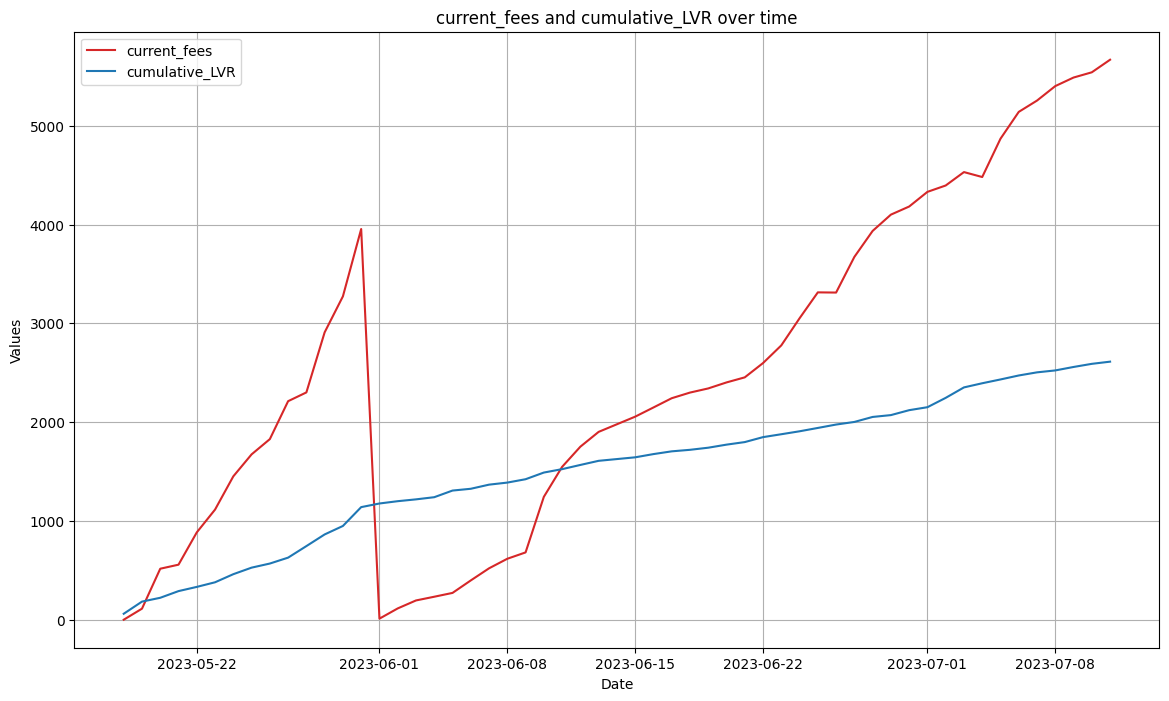

In [123]:
import matplotlib.pyplot as plt

df = merged_df[['date', 'current_fees', 'cumulative_LVR']]
df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
df = df.sort_values('date')

plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['current_fees'], color='tab:red', label='current_fees')
plt.plot(df['date'], df['cumulative_LVR'], color='tab:blue', label='cumulative_LVR')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('current_fees and cumulative_LVR over time')
plt.legend()
plt.grid(True)
plt.show()